### Założenia modelu.

Gdy model regresji spełania jego podstawowe założenia, można uznać, że jest on wiarygodny. Naruszanie założeń może sprawić, że dane nie będą trafnie odzwierciedlały rzeczywistości. Już na etapie analizy danych wykonywałem czynności, które pomogą w spełnianiu założeń.

In [30]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split

from scipy import stats
import statsmodels.api as sm
import statsmodels.stats.api as sms

import pickle

In [31]:
X = pd.read_pickle('./pickle/X.pickle')
y = pd.read_pickle('./pickle/y.pickle')

lm = pickle.load(open('.\pickle\linear_model.pickle', 'rb'))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=60)

X_const = sm.add_constant(X_train)
ols = sm.OLS(y_train, X_const).fit()

lm.fit(X_train, y_train)
prediction = lm.predict(X_test) 
residuals = prediction - y_test 

#### 1 Liniowość

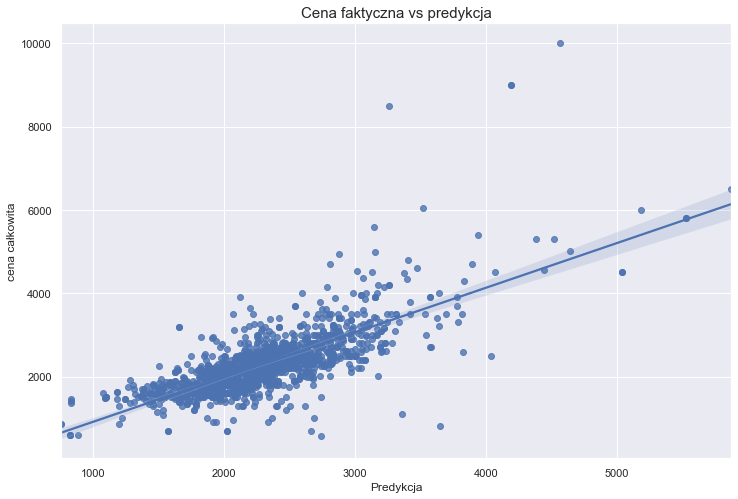

In [32]:
plt.figure(figsize = (12,8))
plt.xlabel('Predykcja')
plt.ylabel('Cena faktyczna')
plt.title('Cena faktyczna vs predykcja', fontdict={'fontsize':15})
sns.regplot(x=prediction, y=y_test)
plt.show()

In [33]:
ols.f_pvalue # p_value dla F-statistic

0.0

Rozkład składników resztowych wskazuje na liniową zależność między ceną, a pozostałymi zmiennymi. Pojawiają się jednak wartości skrajne pod i nad linią regresji. Założenie liniowości można potwierdzić patrząc na wartość.

#### 2 Homoskedastyczność składników resztowych (stałość wariancji)

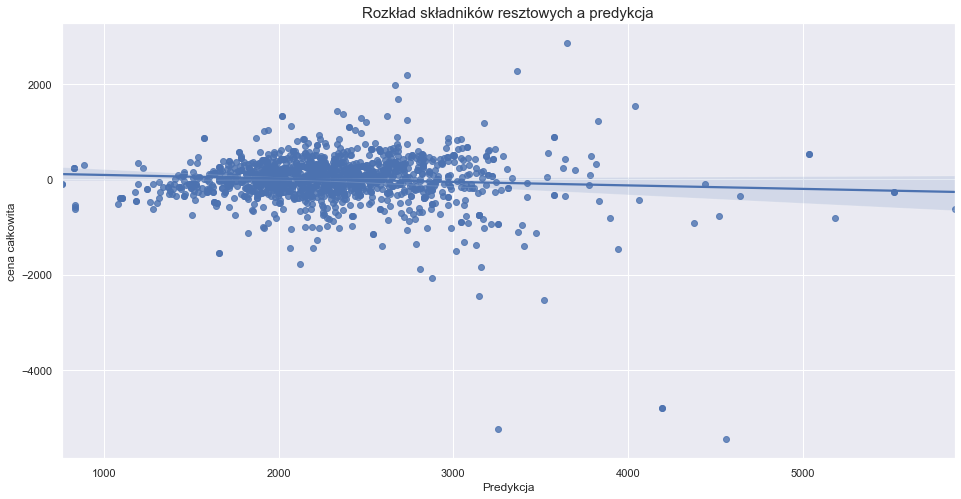

In [34]:
plt.figure(figsize=(16,8))
plt.xlabel('Predykcja')
plt.ylabel('Reszty')
plt.title('Rozkład składników resztowych a predykcja', fontdict={'fontsize':15})
sns.regplot(x=prediction, y=residuals )
plt.show()

Większość obserwacji mieści się w granicy błędu od -1000 do 1000. Wartości skrajne zaburzają homoskedastyczność rozkładu.

In [35]:
test = sms.het_goldfeldquandt(ols.resid, ols.model.exog)
print(f'F-statistic: {test[0]:.4f}, p-value: {test[1]:.4f}')
if test[1] < 0.05:
    print('Nie występuje homoskedastyczność')
else:
    print('Występuje homoskedastyczność')

F-statistic: 1.1434, p-value: 0.0065
Nie występuje homoskedastyczność


#### 3 Normalność rozkładu składników resztowych

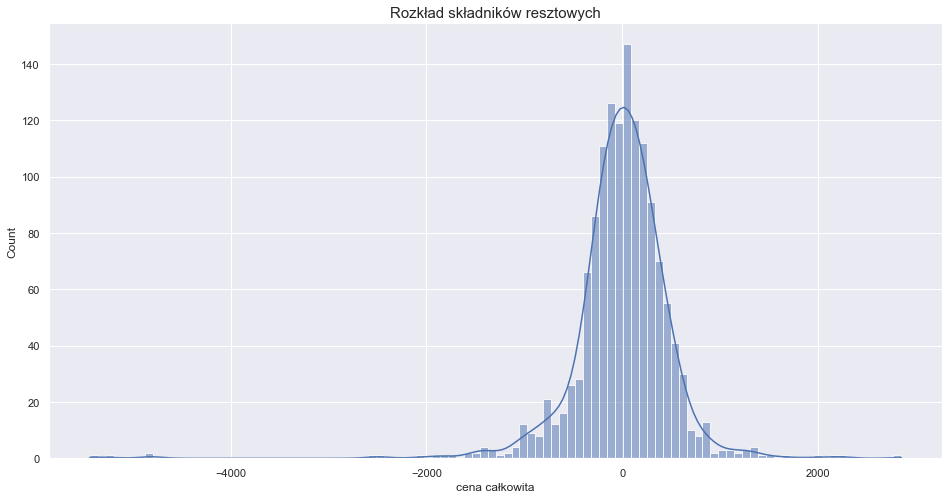

In [36]:
plt.figure(figsize=(16,8))
plt.title('Rozkład składników resztowych', fontdict={'fontsize':15})
sns.histplot(residuals, kde=True)
plt.show()

In [37]:
print('''Badanie normalności składników resztowych
H_0 - występuje rokład normalny
H_1 - brak rozkładu normalnego
a = 0.05
''')

stat, p = stats.normaltest(residuals)
print(f'p_value: {p:.5f}')

if p > 0.05:
    print('Nie ma podstaw do odrzucenia hipotezy zerowej. Występuje rozkład normalny.')
else:
    print('Odrzucamy hipotezę zerową na rzecz hipotezy alternatywnej. Brak rozkładu normalnego.')

Badanie normalności składników resztowych
H_0 - występuje rokład normalny
H_1 - brak rozkładu normalnego
a = 0.05

p_value: 0.00000
Odrzucamy hipotezę zerową na rzecz hipotezy alternatywnej. Brak rozkładu normalnego.


Składniki resztowe nie mają rozkładu normalnego. Te założenie regresji jest naruszone. Dane mają zbyt dużą kurtozę i za dużo wartości skrajnych. Trzeba więc założyć, że przedziały ufności i odchylenia standardowe nie są godne zaufania.

#### 4 Brak współliniowości zmiennych objaśniających

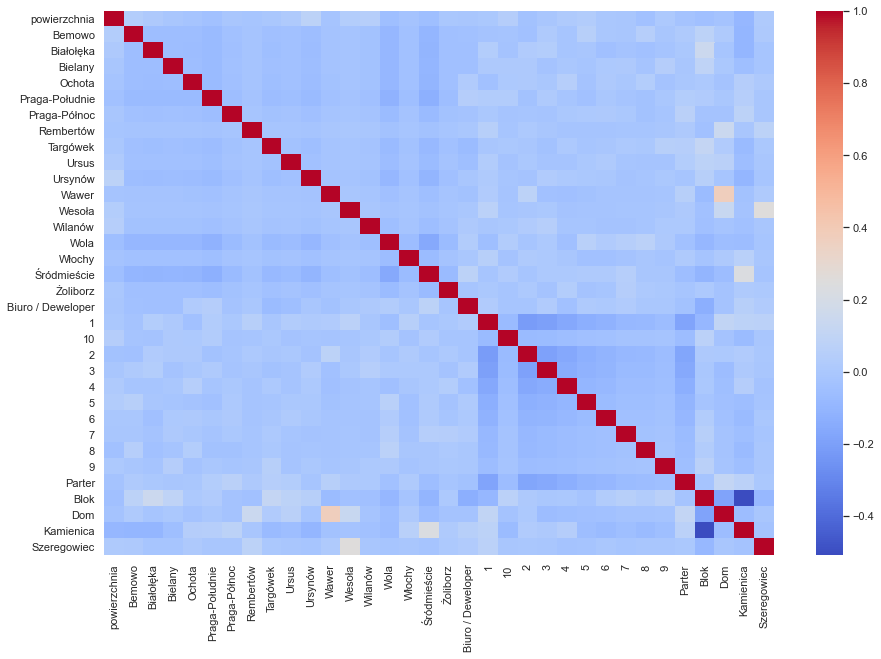

In [38]:
plt.figure(figsize=(15,10))
sns.heatmap(X.corr(), cmap='coolwarm')
plt.show()

Założenie to wskazuje, że zmienne objaśniające nie mogą być ze sobą skorelowane. Wcześniejsze usuięcie kolumny "pokoje", oraz usunięcie po jednej kolumny ze zmiennych dummies, pozwalają spełnić te założnie. Na mapie ciepła, widać że niektóre zmienne są skorelowane, ale mają one raczej marginalne znaczenie np. Dom i Wawer. Wskazują one bardziej na charakter miejsca, a nie objaśniają wpływu na cenę.